In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import scipy.io as sio
import pandas as pd
import time
import cv2
from skimage.transform import resize

In [3]:
path_data='/content/drive/MyDrive/dataset/InBreast_kaggle/ALL-IMGS/'
folders=glob.glob(path_data+'*.dcm') #410 imagenes de 115 sujetos
excel=pd.read_excel('/content/drive/MyDrive/dataset/InBreast_kaggle/INbreast.xls')

In [4]:
def get_mat_ima():
  mats=sio.loadmat('/content/drive/MyDrive/dataset/InBreast_kaggle/imagenes.mat')
  im_1=mats['images']
  for ix in range(410):
    im_1[ix]=im_1[ix]*255/np.max(im_1[ix])
  im_1=im_1.astype('uint8')
  return im_1

In [5]:
imas=get_mat_ima()
classes=np.array(excel.loc[:,'Bi-Rads'][:-2])
conver={'0':0, '1':1, '2':2, '3':3, '4a':4, '4b':5, '4c':6, '5':7, '6':8}  #Bi-Rads

In [6]:
def conver_f(val):
  return conver[str(val)]
vec=np.vectorize(conver_f)
vec_c=vec(classes)

Text(0.5, 1.0, '2')

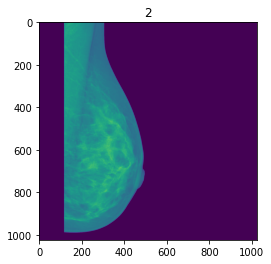

In [7]:
ind=np.random.choice(410)
plt.imshow(imas[ind])
plt.title(vec_c[ind])

In [8]:
def one_hot(vec):
  vec = vec-1
  shape = (vec.size, 8)
  one = np.zeros(shape)
  rows = np.arange(vec.size)
  one[rows, vec.astype('int')] = 1
  return one

In [9]:
train_id=[]
valid_id=[]
test_id =[]

for i in range(1,9):
  poscls=np.where(vec_c==i)[0]
  sz=np.shape(poscls)[0]
  rind=np.random.choice(sz,sz,replace=False)

  train_id=np.append(train_id, poscls[rind][:int(sz*0.6)])
  valid_id=np.append(valid_id, poscls[rind][int(sz*0.6):int(sz*0.8)])
  test_id =np.append(test_id,  poscls[rind][int(sz*0.8):])
stn=np.shape(train_id)[0]
sva=np.shape(valid_id)[0]
stt=np.shape(test_id )[0]

train_id=train_id[np.random.choice(stn,stn,replace=False)]
valid_id=valid_id[np.random.choice(sva,sva,replace=False)]
test_id =test_id[np.random.choice(stt,stt,replace=False)]

In [10]:
def get_index(inds_0):
  subx=np.shape(inds_0)[0]
  rando_ind=np.random.choice(subx,subx,replace=False)

  train_id=rando_ind[:int(subx*0.7)]
  valid_id=rando_ind[int(subx*0.7):int(subx*0.85)]
  test_id =rando_ind[int(subx*0.85):]
  return train_id, valid_id, test_id

In [11]:
kernel=[(0,0), (0,2), (1,1), (1,3), (2,0), (2,2), (3,1), (3,3)]
def get_ima(tam, pk, ima, x_id):
  ver=np.zeros((tam,tam))
  hor=np.zeros((tam,tam))
  ver[np.arange(tam)%4==kernel[pk][0],:]=1
  hor[:,np.arange(tam)%4==kernel[pk][1]]=1
  #ima=ima[...,0]
  ima=ima[ver*hor==1].reshape((int(tam/4),int(tam/4)))
  if kernel[pk][0]>=2:
    ima=np.flip(ima, axis=0)
  ima=np.rot90(ima,kernel[pk][1])
  lab=vec_c[x_id]
  return ima, int(lab)

In [12]:
def get_data_reduction(x_id, Fourier=False, pk=np.random.choice(8), aug=True):
  tam=1024
  ima = imas[x_id]
  
  if np.shape(ima)[0]!=tam:
    print('Size error')
  else:
    if aug:
      imaOu=np.zeros((8,int(tam/4),int(tam/4)))
      lab2=[]
      for pk in range(8):
        im, la=get_ima(tam, pk, ima, x_id)
        imaOu[pk]=im
        lab2=np.append(lab2,la)
      return imaOu, lab2
    else:
      return get_ima(tam, pk, ima, x_id)

In [13]:
xx, yy=get_data_reduction(5, aug=True)
np.shape(xx), np.shape(yy)

((8, 256, 256), (8,))

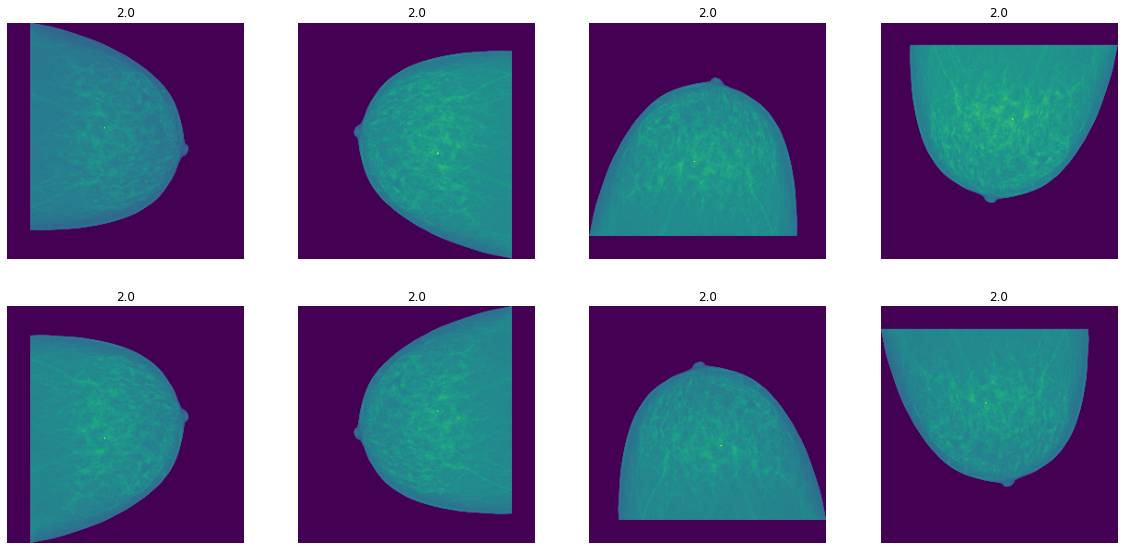

In [14]:
plt.figure(figsize=(20,20))
for i in range(8):
  plt.subplot(4,4,i+1)
  plt.title(yy[i])
  plt.imshow(xx[i])
  plt.axis('off')

In [15]:
import tensorflow as tf

In [16]:
def get_matrix(ind_0, aug=False, rgb=True):
  sz=np.shape(ind_0)[0]
  ima,lab=get_data_reduction(ind_0[0], aug=aug)   #imagenes y etiquetas
  szx=np.shape(ima)
  mat=np.zeros((sz*(1+int(aug)*7),szx[0+int(aug)],szx[1+int(aug)]))
  labels=[]

  for n,ix in enumerate(ind_0):
    ima,lab=get_data_reduction(ix, aug=aug)       #imagenes y etiquetas
    mat[n*(1+int(aug)*7):(n+1)*(1+int(aug)*7)]=ima
    labels=np.append(labels, lab)
    print("\rprocess ", round((n+1)*100/sz, 2), "%", end="")
  mat=tf.convert_to_tensor(mat.reshape(np.shape(mat)+(1,)))
  labels=tf.convert_to_tensor(one_hot(labels))
  if rgb:
    return tf.image.grayscale_to_rgb(mat), labels
  else:
    return mat, labels

In [17]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [18]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [19]:
def get_index2(inds_0):
  train_id=[]
  valid_id=[]
  test_id =[]

  for i in range(1,9):
    poscls=np.where(inds_0==i)[0]
    sz=np.shape(poscls)[0]
    rind=np.random.choice(sz,sz,replace=False)

    train_id=np.append(train_id, poscls[rind][:int(sz*0.6)])
    valid_id=np.append(valid_id, poscls[rind][int(sz*0.6):int(sz*0.8)])
    test_id =np.append(test_id,  poscls[rind][int(sz*0.8):])
  stn=np.shape(train_id)[0]
  sva=np.shape(valid_id)[0]
  stt=np.shape(test_id )[0]

  train_id=train_id[np.random.choice(stn,stn,replace=False)].astype('int')
  valid_id=valid_id[np.random.choice(sva,sva,replace=False)].astype('int')
  test_id =test_id[np.random.choice(stt,stt,replace=False)].astype('int')
  
  return train_id, valid_id, test_id

In [20]:
train,valid,test=get_index2(vec_c)
x_train, y_train=get_matrix(train, True)
x_valid, y_valid=get_matrix(valid, True)
x_test , y_test =get_matrix(test,  True)
del imas

process  100.0 %

In [21]:
from tensorflow.keras import applications as ap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [22]:
Networs=['DenseNet121', 'InceptionResNetV2', 'ResNet50V2', 'VGG19', 'Xception', 'InceptionV3']
def get_model(network, opt='adadelta', loss_name='categorical_crossentropy', input_shape=(256,256,3)):
  try:
    del model
  except:
    print('done')
  model=Sequential()
  if network=='ResNet50V2':
    model.add(ap.ResNet50V2(include_top=False, input_shape=input_shape, pooling='avg', classes=8)) # The input must have 3 channels
  if network=='EfficientNetB7':
    model.add(ap.EfficientNetB7(include_top=False, input_shape=input_shape, pooling='avg', classes=8)) 
  if network=='InceptionResNetV2':
    model.add(ap.InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg', classes=8)) 
  if network=='InceptionV3':
    model.add(ap.InceptionV3(include_top=False, input_shape=input_shape, pooling='avg', classes=8)) 
  if network=='NASNetLarge':
    model.add(ap.NASNetLarge(include_top=False, input_shape=input_shape, pooling='avg', classes=8))
  if network=='VGG19':
    model.add(ap.VGG19(include_top=False, input_shape=input_shape, pooling='avg', classes=8)) 
  if network=='Xception':
    model.add(ap.Xception(include_top=False, input_shape=input_shape, pooling='avg', classes=8))
  if network=='DenseNet121':
    model.add(ap.DenseNet121(include_top=False, input_shape=input_shape, pooling='avg', classes=8))
  
  model.add(Dense(8, activation='softmax'))
  model.compile(optimizer=opt, loss=loss_name, metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives()])
  return model

In [23]:
df = pd.DataFrame(columns=('run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time', 'augm', 'Class', 'TP', 'TN', 'FP', 'FN','result_mat'))
df.head()

,run_n,network,optimizer,loss,epochs,total_parameters,time,augm,Class,TP,TN,FP,FN,result_mat


In [24]:
from IPython.display import clear_output

path2='/content/drive/MyDrive/INDIGO_MLR/CancerDeMama_INB/data_augmentation/'
pathW='/content/drive/MyDrive/INDIGO_MLR/CancerDeMama_INB/Weights/'
augmentation='partsRotated'
optimizer='adadelta'
epochs=40
loss='categorical_crossentropy'

In [25]:
TP=tf.keras.metrics.TruePositives()
TN=tf.keras.metrics.TrueNegatives()
FP=tf.keras.metrics.FalsePositives()
FN=tf.keras.metrics.FalseNegatives()

In [26]:
for net in Networs:

  name_0='_'.join(['clasification_t',augmentation,net,optimizer])
  if not os.path.exists(path2+name_0+'.csv'):
    df.to_csv(path2+name_0+'.csv')

  for i in range(80): #Numero corridas 
    for j in [loss]: #Funciones de perdida
      cntn=True
      name_m='_'.join([name_0,j,'run',str(i)])  
      print(name_m)

      #Obtener imagenes nuevamente
      imas=get_mat_ima()
      train,valid,test=get_index(vec_c)
      x_train, y_train=get_matrix(train, True)
      x_valid, y_valid=get_matrix(valid, True)
      x_test , y_test =get_matrix(test,  True)
      y_test=y_test>=0.5
      del imas

      model=get_model(net)
      
      try:
        tic = time.time()
        #results = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs)
        results = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=10, epochs=epochs)
        toc=time.time()-tic
        model.save_weights(pathW+name_m+"w.h5")
      except:
        print('Training error')
        cntn=False

      if cntn:
        sio.savemat(pathW+name_m+'_r.mat', results.history)

        #Validation
        y_hat=np.array(model.predict(x_test))
        sio.savemat(pathW+name_m+'_los_8.mat',{'y_hat': y_hat, 'y_test': np.array(y_test)})
        y_hat=y_hat>=0.5

        for class_i in range(7):
          TP.reset_state()
          TN.reset_state()
          FP.reset_state()
          FN.reset_state()        

          TP.update_state(y_test[:,class_i], y_hat[:,class_i])
          TN.update_state(y_test[:,class_i], y_hat[:,class_i])
          FP.update_state(y_test[:,class_i], y_hat[:,class_i])
          FN.update_state(y_test[:,class_i], y_hat[:,class_i])
          total_p=model.count_params()

          #data frame
          df2=pd.read_csv(path2+name_0+'.csv')
          df2=df2.append({'run_n': i,
                        'network': net,
                        'optimizer': optimizer,
                        'loss': 'categorical_crossentropy',
                        'epochs': epochs,
                        'total_parameters': total_p,
                        'time': toc,
                        'augm': augmentation,
                        'Class': class_i,
                        'TP': float(TP.result()),
                        'TN': float(TN.result()),
                        'FP': float(FP.result()),
                        'FN': float(FN.result()),
                        'result_mat': name_m+'_r.mat'} , ignore_index=True)
          df2=df2.drop(df2.columns[:np.where(df2.columns=='run_n')[0][0]], axis=1)
          df2.to_csv(path2+name_0+'.csv')
        del train, valid, test, x_train, y_train, x_valid, y_valid, x_test, y_test, model
        clear_output(wait=True)

clasification_t_partsRotated_DenseNet121_adadelta_categorical_crossentropy_run_79
process  100.0 %done
29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/40
230/230 [==============================] - 57s 128ms/step - loss: 2.3688 - acc: 0.1546 - recall: 0.0017 - false_positives_1: 31.0000 - val_loss: 2.3981 - val_acc: 0.1619 - val_recall: 0.0020 - val_false_positives_1: 8.0000
Epoch 2/40
230/230 [==============================] - 26s 114ms/step - loss: 2.1235 - acc: 0.2997 - recall: 0.0087 - false_positives_1: 25.0000 - val_loss: 2.1490 - val_acc: 0.3135 - val_recall: 0.0307 - val_false_positives_1: 9.0000
Epoch 3/40
230/230 [==============================] - 26s 115ms/step - loss: 1.9439 - acc: 0.4190 - recall: 0.0357 - false_positives_1: 28.0000 - val_loss: 2.0087 - val_acc: 0.3955 - val_recall: 0.0594 - val_false_positives_1: 12.0000
Epoch 4/40
230/230 [==============================] - 26s 113ms/step - loss: 1.8041 - acc: 0.4856 - recall: 0.0788 - false_positi